In [49]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math as m
import numpy.matlib

In [50]:
# load data
train_data = pd.read_csv('TrainDigitX.csv')
test_data = pd.read_csv('TestDigitX.csv')
train_data['labels'] = pd.read_csv('TrainDigitY.csv')
test_data['labels'] = pd.read_csv('TestDigitY.csv')

In [51]:
# Checking the number of examples in our training data
len(train_data)

49999

In [52]:
# Checking the number of examples in our test data
len(test_data)

9999

In [53]:
# taking a look at our training data
train_data.head(2)

,0.000000,0.000000.1,0.000000.2,0.000000.3,0.000000.4,0.000000.5,0.000000.6,0.000000.7,0.000000.8,0.000000.9,...,0.000000.609,0.000000.610,0.000000.611,0.000000.612,0.000000.613,0.000000.614,0.000000.615,0.000000.616,0.000000.617,labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


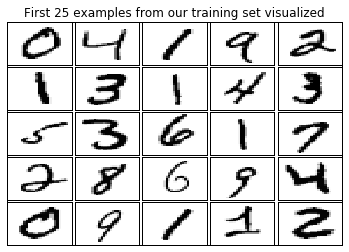

In [187]:
# Visualizing the first 25 images from our training set
fig = plt.figure()
plt.clf()
plt.title('First 25 examples from our training set visualized')
plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', 
                    left='off', labelleft='off')

for i in range(25):
    ax = fig.add_subplot(5,5,i+1) 
    image_1 = train_data.loc[i,:][0:784]
    image_1 = image_1.reshape(28,28)
    plt.imshow(image_1, cmap='Greys', interpolation = 'nearest' )
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0.05, hspace=0.05)

plt.show()

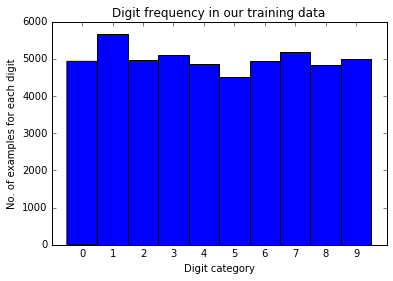

In [55]:
plt.figure()
plt.title('Digit frequency in our training data')
plt.hist(train_data['labels'],bins=np.arange(11)-0.5)
plt.xticks(range(10))
plt.xlim([-1, 10])
plt.ylabel('No. of examples for each digit')
plt.xlabel('Digit category')
plt.show()

## Creating Validation set:

In [56]:
# A function for determing the indeces of our examples that will be included in our training and validation data
def get_train_valid_inds(y,train_proportion):
    y=np.array(y)
    train_inds = np.zeros(len(y),dtype=bool)
    valid_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y)
    for value in values:
        value_inds = np.nonzero(y==value)[0]
        np.random.shuffle(value_inds)
        n = int(train_proportion*len(value_inds))

        train_inds[value_inds[:n]]=True
        valid_inds[value_inds[n:]]=True
    return train_inds,valid_inds

In [57]:
train_inds, valid_inds = get_train_valid_inds(train_data['labels'], 0.8)

In [58]:
# Separating our previous training data into our new training data on which we will train our models and the validation data
# which we will use later to determine the best values for the model parameters
train_data_new = train_data.loc[train_inds]
validation_data = train_data.loc[valid_inds]

In [59]:
len(train_data_new)

39995

In [60]:
len(validation_data)

10004

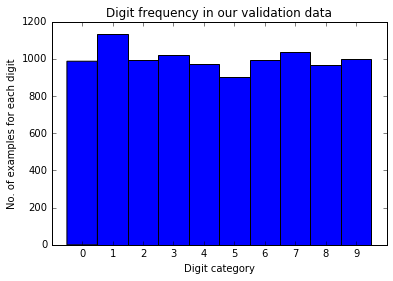

In [61]:
plt.figure()
plt.title('Digit frequency in our validation data')
plt.hist(validation_data['labels'],bins=np.arange(11)-0.5)
plt.xticks(range(10))
plt.xlim([-1, 10])
plt.ylabel('No. of examples for each digit')
plt.xlabel('Digit category')
plt.show()
# From the plot below we can see that the structure of the data in a validation set is preserved and that all the classes are 
#represented almost equally

## Building a neural network with two hidden layers + L2 Regularization:

In [85]:
#Defining the neural network parameters:

input_layer_size = 784       # 28x28 Input Images of Digits
hidden_layer_size1 = 300        # num of hidden units in the first hidden layer
hidden_layer_size2 = 300        # num of hidden units in the second hidden layer
num_labels = 10               # 10 labels, from 1 to 10

X_train = train_data_new.drop(['labels'], axis=1)
X_train = np.array(X_train)
Y_train = np.array(train_data_new['labels'])
X_validate = np.array(validation_data.drop(['labels'], axis=1))
Y_validate = np.array(validation_data['labels'])
num_training_examples = len(X_train)
num_validation_examples = len(X_validate)
mini_batch_size = 50
alpha = 0.0005  # weight decay parameter (L2 regularization parameter)

In [86]:
# Initalizing weights for our model

def Weights_Initialization2(input_layer_size, hidden_layer_size1,hiden_layer_size2, num_labels):
    r1 = m.sqrt(6/float(input_layer_size+1+hidden_layer_size1))
    r2 = m.sqrt(6/float(hidden_layer_size1+1+hidden_layer_size2))
    r3 =m.sqrt(6/float(hidden_layer_size2+1+num_labels))
    np.random.seed(0)
    Theta_1 = (np.random.rand(hidden_layer_size1, input_layer_size)*2*r1)-r1
    b1 = (np.random.rand(hidden_layer_size1)*2*r1)-r1
    
    Theta_2 = (np.random.rand(hidden_layer_size2, hidden_layer_size1)*2*r2)-r2
    b2 = (np.random.rand(hidden_layer_size2)*2*r2)-r2
    
    Theta_3 = (np.random.rand(num_labels, hidden_layer_size2)*2*r3)-r3
    b3 = (np.random.rand(num_labels)*2*r3)-r3
    
    return Theta_1, Theta_2, Theta_3, b1, b2, b3

In [87]:
# Defining a function that we will call later whenever we need to do a feedforward step

def FeedforwardCalculation2(X, Theta_1, Theta_2, Theta_3, b1, b2, b3):
    z1 = np.dot( X, Theta_1.T) + b1
    a2 = np.tanh(z1)
    z2 = np.dot(a2, Theta_2.T) + b2
    a3 = np.tanh(z2)
    z3 = np.dot(a3, Theta_3.T) + b3
     
    exponentials = np.exp(z3)
    y_predicted = exponentials / np.sum(exponentials, axis=1, keepdims=True)
          
    return a2, a3, y_predicted

In [110]:
# Cross entropy loss is used
def Loss_Calculation(Y_predicted, Y_real):
    n = len(Y_predicted)
    Loss = 1/float(n)*np.sum(-np.log(Y_predicted[range(n),Y_real]))
    return Loss

In [113]:
def Accuracy(Y_predicted, Y_real):
    n = len(Y_predicted)
    count = np.sum(Y_predicted.T == Y_real)
    Accuracy = float(count)/n
    Error = 1-Accuracy
    return Accuracy, Error

In [90]:
def BackpropagationCalculation2(Y_predicted, Y_real, Theta_1,Theta_2,Theta_3,b1, b2, b3, X, a2,a3, learning_rate, mini_batch_size):

    delta4 = Y_predicted - Y_real
    delta3 = np.dot(delta4, Theta_3 )*(1 - a3**2)
    delta2 = np.dot(delta3, Theta_2 )*(1 - a2**2)
    
    DELTA_3 = np.dot(a3.T, delta4) + alpha*Theta_3.T
    DELTA_2 = np.dot(a2.T, delta3) + alpha*Theta_2.T
    DELTA_1 = np.dot(X.T, delta2) + alpha*Theta_1.T
    DELTA_b3 = np.sum(delta4, axis=0, keepdims=True)
    DELTA_b2 = np.sum(delta3, axis=0, keepdims=True)
    DELTA_b1 = np.sum(delta2, axis=0)
    
    # Updating both weights (Theta_1, Theta_2 and Theta_3) and biases (b1. b2 and b3)
    Theta_1 = Theta_1 - 1/float(mini_batch_size)*learning_rate * DELTA_1.T
    Theta_2 = Theta_2 - 1/float(mini_batch_size)*learning_rate * DELTA_2.T
    Theta_3 = Theta_3 - 1/float(mini_batch_size)*learning_rate * DELTA_3.T
    b1 = b1 - 1/float(mini_batch_size)*learning_rate * DELTA_b1
    b2 = b2 - 1/float(mini_batch_size)*learning_rate * DELTA_b2
    b3 = b3 - 1/float(mini_batch_size)*learning_rate * DELTA_b3
    
    return Theta_1, Theta_2, Theta_3, b1, b2, b3

In [91]:
def create_minibatches(X_train, Y_train, batchsize, shuffle=False):
    assert X_train.shape[0] == Y_train.shape[0]
    if shuffle:
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, X_train.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield X_train[excerpt], Y_train[excerpt]

In [216]:
def Building_the_model2(input_layer_size,hidden_layer_size1, hidden_layer_size2, num_labels, learning_rate, X_train, Y_train, 
                        X_validate, Y_validate, mini_batch_size, num_validation_examples, max_num_epochs):
    
    # Initializing weights
    Theta_1, Theta_2, Theta_3, b1, b2, b3 = Weights_Initialization2(input_layer_size, hidden_layer_size1, hidden_layer_size2,
                                                                   num_labels)
    A = np.matlib.repmat(np.arange(10), mini_batch_size,1)
    epoch_num = 0
    validation_error = []
    loss_on_validation_set =[] 
    training_error = []
    
    while epoch_num <=max_num_epochs:
        
        # Compute an error and loss on validation set:
        # First we need to do a feedforward step using features in validation set:
        
        a2_valid, a3_valid, Y_predicted_valid = FeedforwardCalculation2(X_validate, Theta_1, Theta_2, Theta_3, b1, b2, b3)
        Y_pred_output_valid = np.argsort(Y_predicted_valid, axis = 1)[:,-1]
        Y_pred_output_valid = Y_pred_output_valid.reshape(-1,1)
        
        Accuracy_valid, Error_valid = Accuracy(Y_pred_output_valid, Y_validate)
        loss_valid = Loss_Calculation(Y_predicted_valid, Y_validate)
        
        validation_error.append(Error_valid)
        loss_on_validation_set.append(loss_valid)
        
        if epoch_num % 5 == 0:
            print epoch_num,Error_valid,loss_valid
        
        # Do a feedforward step on our training data to obtain error and accuracy for our training data for each epoch
        a2, a3, Y_predicted_train = FeedforwardCalculation2(X_train, Theta_1, Theta_2, Theta_3, b1, b2, b3)
        Y_pred_output_train = np.argsort(Y_predicted_train, axis = 1)[:,-1]
        Y_pred_output_train = Y_pred_output_train.reshape(-1,1)
            
        # Calculcate Accuracy on our training data:
        Accuracy_train, Error_train = Accuracy(Y_pred_output_train, Y_train)
        training_error.append(Error_train)
        
        # Applying Stochastic Gradient Descent with mini batch size of 50:

        for batch in create_minibatches(X_train, Y_train, mini_batch_size, shuffle=True):
            x_batch, y_batch = batch
            y_batch_matrix = (np.matlib.repmat(y_batch,10,1).T ==A).astype(int)
            
            # Do a feedforward step
            a2, a3, Y_predicted_train = FeedforwardCalculation2(x_batch, Theta_1, Theta_2, Theta_3, b1, b2, b3)
               
            # Do a backprop step
            Theta_1, Theta_2, Theta_3, b1, b2, b3 = BackpropagationCalculation2(Y_predicted_train, y_batch_matrix, Theta_1, 
                                                                                Theta_2, Theta_3, b1, b2, b3,x_batch, a2, a3, 
                                                                                learning_rate, mini_batch_size)
        epoch_num += 1

    return Theta_1, Theta_2, Theta_3, b1, b2, b3, epoch_num, validation_error, loss_on_validation_set, training_error

In [189]:
# Trying out different learning rates
learning_rates = [0.0003, 0.003, 0.03, 0.1]

Loss_validation_dict = dict()

for lr in learning_rates:
        
    Theta_1, Theta_2, Theta_3, b1, b2, b3,epoch_num,validation_error,loss_on_validation_set, training_error = \
                                                         Building_the_model2(input_layer_size, hidden_layer_size1, 
                                                         hidden_layer_size2, num_labels, lr,X_train, Y_train, X_validate, 
                                                         Y_validate, mini_batch_size, num_validation_examples,50)
    Loss_validation_dict[ str(lr) ] = loss_on_validation_set

0 0.917433026789 2.36957990804
5 0.212415033986 1.00652711395
10 0.167033186725 0.70519630672
15 0.148040783687 0.584770590252
20 0.137345061975 0.51937626218
25 0.129148340664 0.477805502881
30 0.123150739704 0.448703357712
35 0.118152738904 0.427107215786
40 0.114954018393 0.410222348859
45 0.110955617753 0.396670964274
0 0.917433026789 2.36957990804
5 0.108256697321 0.385891031936
10 0.09356257497 0.328704660667
15 0.0878648540584 0.303549057637
20 0.0829668132747 0.285840012618
25 0.078068772491 0.272314362908
30 0.0754698120752 0.259718998662
35 0.0729708116753 0.248190703973
40 0.0689724110356 0.236689583778
45 0.0648740503798 0.225194956337
0 0.917433026789 2.36957990804
5 0.062275089964 0.219663732264
10 0.0445821671331 0.155024310685
15 0.0372850859656 0.124098369604
20 0.0328868452619 0.109191995124
25 0.030787684926 0.0974746566805
30 0.0282886845262 0.0912281392384
35 0.0274890043982 0.0897670577497
40 0.0262894842063 0.088968217276
45 0.0264894042383 0.0881229716363
0 0.91

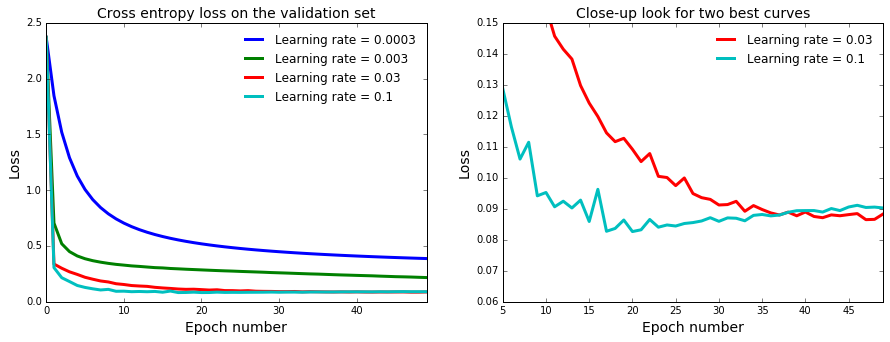

In [206]:
plt.figure(figsize=(15,5))
plt.clf()
plt.subplot(1,2,1)
for lr in learning_rates:
    plt.plot(range(0,epoch_num), Loss_validation_dict[ str(lr) ],'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.xlim(0,50)
plt.legend(['Learning rate = 0.0003','Learning rate = 0.003','Learning rate = 0.03',
           'Learning rate = 0.1'],frameon = False)
plt.title('Cross entropy loss on the validation set',fontsize = 14)

plt.subplot(1,2,2)
col = ['r','c']
learning_rates2 = [0.03, 0.1]
count = 0
for lr in learning_rates2:
    plt.plot(range(0,epoch_num), Loss_validation_dict[ str(lr) ],color = col[count],linestyle = '-',lw=3)
    count+=1
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.xlim(5,50)
plt.ylim(0.06,0.15)
plt.legend(['Learning rate = 0.03','Learning rate = 0.1'],frameon = False)
plt.title('Close-up look for two best curves',fontsize = 14)
plt.show()

From the figure above we can see that for the learning rates of 0.03 and 0.1 we get the similar loss after 35 epochs, but learning rate of 0.1 enable us to lower the loss faster, while the learning rate of 0.03 will allow us to reduce the loss maybe even after the 50 epochs. The learning rate of 0.1 will be used as an optimal rate for a speed efficiency, but the optimal solution would be to use this rate for the first 20 epochs and then use the lower rate as we get closer to optimum solution.

We will train the chosen model only for 20 epochs. Early stopping is used to prevent overfitting.

In [217]:
# Running our final model with 2 hidden layers of sizes 300 and 300 respectively and learning rate of 0.1 to obtain 
# needed weights:
learning_rate = 0.1
Theta_1, Theta_2, Theta_3, b1, b2, b3, epoch_num,validation_error, loss_on_validation_set, training_error = \
                                                         Building_the_model2(input_layer_size, hidden_layer_size1, 
                                                         hidden_layer_size2, num_labels, learning_rate,X_train, Y_train, 
                                                         X_validate, Y_validate, mini_batch_size, num_validation_examples,20)

0 0.917433026789 2.36957990804
5 0.0391843262695 0.128786802596
10 0.0289884046381 0.0952624661582
15 0.0256897241104 0.0859046978829
20 0.0243902439024 0.0826579279482


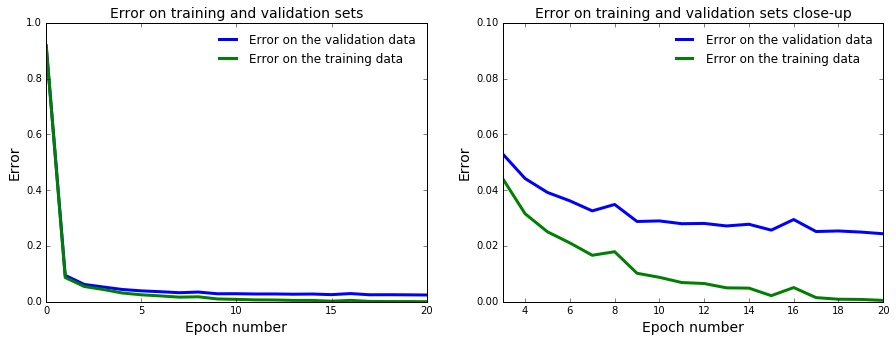

In [222]:
plt.figure(figsize=(15,5))
plt.clf()
plt.subplot(1,2,1)
plt.plot(range(0,epoch_num), validation_error,'-',lw=3)
plt.plot(range(0,epoch_num), training_error,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xlim(0,20)
plt.ylim(0.,1.)
plt.legend(['Error on the validation data','Error on the training data'],frameon = False)
plt.title('Error on training and validation sets',fontsize = 14)

plt.subplot(1,2,2)
plt.plot(range(0,epoch_num), validation_error,'-',lw=3)
plt.plot(range(0,epoch_num), training_error,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xlim(3,20)
plt.ylim(0,0.1)
plt.legend(['Error on the validation data','Error on the training data'],frameon = False)
plt.title('Error on training and validation sets close-up',fontsize = 14)
plt.show()

As we can see from the close up figure above, the difference between error on the validation set and training set is not too large which supports the claim that there is not too much overfitting present. 

In [223]:
X_test = np.array(test_data.drop(['labels'], axis=1))
Y_test = np.array(test_data['labels'])

In [234]:
# Doing feedforward step on test data to obtain predicted labels in order to calculate the accuracy of our model
a2_test, a3_test, Y_predicted_test = FeedforwardCalculation2(X_test, Theta_1, Theta_2,Theta_3, b1, b2, b3)
Y_pred_output_test = np.argsort(Y_predicted_test, axis = 1)[:,-1]
Y_pred_output_test = Y_pred_output_test.reshape(-1,1)
        
Accuracy_test, Error_test = Accuracy(Y_pred_output_test, Y_test)        
print('Accuracy of the model on the test data is %.2f%% ' % (100*Accuracy_test),
      'Error on the test data is %.2f%%' % (100*Error_test))

('Accuracy of our model on the test data is 97.82% ', 'Error on the test data is 2.18%')


## Same model architecture as before but with RMSProp implementation

In [240]:
# Configuration of the neural network parameters
learning_rate = 0.003 # The learning rate of 0.1 was too big for this model, the rate of 0.003 is much better
di = 1E-6
mini_batch_size = 50
alpha = 0.0005               # weight decay parameter (L2 regularization parameter)
input_layer_size = 784       # 28x28 Input Images of Digits
hidden_layer_size1 = 300     # num of hidden units in the first hidden layer
hidden_layer_size2 = 300     # num of hidden units in the second hidden layer
num_labels = 10              # 10 labels, from 1 to 10


In [241]:
def BackpropagationCalculation_RMSProp(Y_predicted, Y_real, Theta_1,Theta_2,Theta_3,b1, b2, b3, X, a2,a3,learning_rate,alpha,
                                       mini_batch_size, ro, di, r_1, r_2, r_3):
    delta4 = Y_predicted - Y_real
    delta3 = np.dot(delta4, Theta_3 )*(1 - a3**2)
    delta2 = np.dot(delta3, Theta_2 )*(1 - a2**2)
    
    DELTA_3 = 1/float(mini_batch_size)*(np.dot(a3.T, delta4) + alpha*Theta_3.T)
    DELTA_2 = 1/float(mini_batch_size)*(np.dot(a2.T, delta3) + alpha*Theta_2.T)
    DELTA_1 = 1/float(mini_batch_size)*(np.dot(X.T, delta2) + alpha*Theta_1.T)
    DELTA_b3 = np.sum(delta4, axis=0, keepdims=True)
    DELTA_b2 = np.sum(delta3, axis=0, keepdims=True)
    DELTA_b1 = np.sum(delta2, axis=0)
    
    # Accumulating the gradients:
    r_3 = ro*r_3 +(1-ro)*DELTA_3**2
    r_2 = ro*r_2 +(1-ro)*DELTA_2**2
    r_1 = ro*r_1 +(1-ro)*DELTA_1**2
    
    # Computing update for the weights:
    update_3 = -(learning_rate/(np.sqrt(di+r_3)))*DELTA_3
    update_2 = -(learning_rate/(np.sqrt(di+ r_2)))*DELTA_2
    update_1 = -(learning_rate/(np.sqrt(di+ r_1)))*DELTA_1
    
    # Updating both weights (Theta_1, Theta_2 and Theta_3) and biases (b1. b2 and b3)
    Theta_1 = Theta_1 + update_1.T
    Theta_2 = Theta_2 + update_2.T
    Theta_3 = Theta_3 + update_3.T
    b1 = b1 - 1/float(mini_batch_size)*learning_rate * DELTA_b1
    b2 = b2 - 1/float(mini_batch_size)*learning_rate * DELTA_b2
    b3 = b3 - 1/float(mini_batch_size)*learning_rate * DELTA_b3
    
    return Theta_1, Theta_2, Theta_3, b1, b2, b3,r_1, r_2, r_3

In [242]:
def Building_the_model_RMSProp(input_layer_size,hidden_layer_size1, hidden_layer_size2, num_labels, learning_rate, X_train, 
                                Y_train, X_validate, Y_validate, mini_batch_size, num_validation_examples, max_num_epochs, ro):
    
    # Initializing weights
    Theta_1, Theta_2, Theta_3, b1, b2, b3 = Weights_Initialization2(input_layer_size, hidden_layer_size1, hidden_layer_size2,
                                                                   num_labels)
    r_3 = np.zeros(np.shape(Theta_3)).T
    r_2 = np.zeros(np.shape(Theta_2)).T
    r_1 = np.zeros(np.shape(Theta_1)).T
    
    A = np.matlib.repmat(np.arange(10), mini_batch_size,1)
    epoch_num = 0
    validation_error = []
    loss_on_validation_set = []
    training_error =[]
    
    while epoch_num <=max_num_epochs:
        
        # Compute an error and loss on validation set:
        # First we need to do a feedforward step using features in validation set:
        
        a2_valid, a3_valid, Y_predicted_valid = FeedforwardCalculation2(X_validate, Theta_1, Theta_2, Theta_3, b1, b2, b3)
        Y_pred_output_valid = np.argsort(Y_predicted_valid, axis = 1)[:,-1]
        Y_pred_output_valid = Y_pred_output_valid.reshape(-1,1)
        
        Accuracy_valid, Error_valid = Accuracy(Y_pred_output_valid, Y_validate)
        loss_valid = Loss_Calculation(Y_predicted_valid, Y_validate)
        validation_error.append(Error_valid)
        loss_on_validation_set.append(loss_valid)
        if epoch_num % 5 ==0:
            print epoch_num, Error_valid, loss_valid
            
        # Do a feedforward step on our training data to obtain error and accuracy for our training data for each epoch
        a2, a3, Y_predicted_train = FeedforwardCalculation2(X_train, Theta_1, Theta_2, Theta_3, b1, b2, b3)
        Y_pred_output_train = np.argsort(Y_predicted_train, axis = 1)[:,-1]
        Y_pred_output_train = Y_pred_output_train.reshape(-1,1)
            
        # Calculcate Accuracy on our training data:
        Accuracy_train, Error_train = Accuracy(Y_pred_output_train, Y_train)
        training_error.append(Error_train)
             
        # Applying stochastic gradient descent with RMSprop and mini batch size of 50:

        for batch in create_minibatches(X_train, Y_train, mini_batch_size, shuffle=True):
            x_batch, y_batch = batch
            y_batch_matrix = (np.matlib.repmat(y_batch,10,1).T ==A).astype(int)
            
            # Do a feedforward step
            a2, a3, Y_predicted = FeedforwardCalculation2(x_batch, Theta_1, Theta_2, Theta_3, b1, b2, b3)
                        
            # Do a backprop step
            Theta_1, Theta_2, Theta_3, b1, b2, b3, r_1,r_2, r_3 = BackpropagationCalculation_RMSProp(Y_predicted, y_batch_matrix,
                                                                            Theta_1, Theta_2, Theta_3, b1, b2, b3,x_batch, a2,a3,
                                                                                learning_rate,alpha,mini_batch_size, ro, di,
                                                                                r_1, r_2, r_3)
        epoch_num += 1
    
    return Theta_1, Theta_2, Theta_3, b1, b2, b3, epoch_num, validation_error, loss_on_validation_set, training_error

In [243]:
# Trying out different values for ro values
roes = [0.5, 0.85]
loss_validation_dict1 = dict()

for ro in roes:

    Theta_1, Theta_2, Theta_3, b1, b2, b3, epoch_num, validation_error,loss_on_validation_set, training_error = \
                                                                            Building_the_model_RMSProp(input_layer_size,
                                                                            hidden_layer_size1,hidden_layer_size2, num_labels, 
                                                                            learning_rate,X_train, Y_train,X_validate,Y_validate,
                                                                            mini_batch_size, num_validation_examples,50,ro)
            
    loss_validation_dict1[str(ro)] = loss_on_validation_set

0 0.917433026789 2.36957990804
5 0.0297880847661 0.119615377185
10 0.0225909636146 0.109219664401
15 0.0188924430228 0.086647817725
20 0.0185925629748 0.0840858360028
25 0.0190923630548 0.0831022950094
30 0.0263894442223 0.114771118403
35 0.0210915633747 0.0935059479163
40 0.0176929228309 0.0787343144851
45 0.0183926429428 0.0746126360706
50 0.0179928028788 0.0745589722143
0 0.917433026789 2.36957990804
5 0.031287485006 0.121641551373
10 0.0272890843663 0.123477965597
15 0.0209916033587 0.108750324417
20 0.0196921231507 0.0924271498195
25 0.0193922431028 0.0851771766513
30 0.0191923230708 0.0808615792681
35 0.030787684926 0.126109604525
40 0.0259896041583 0.124127688834
45 0.0242902838864 0.119695377432
50 0.0188924430228 0.0925599778812


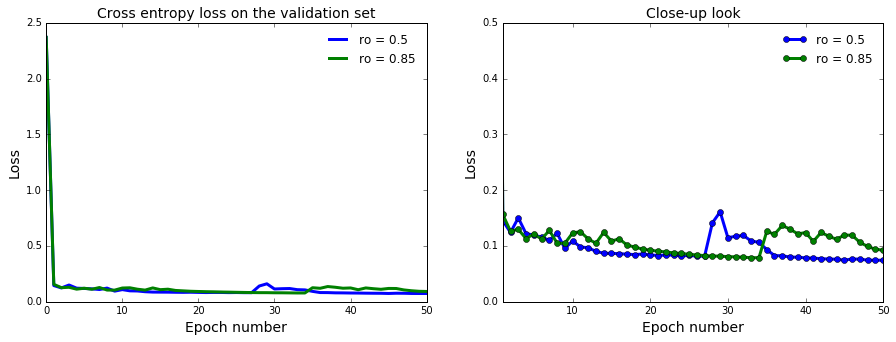

In [252]:
plt.figure(figsize=(15,5))
plt.clf()
plt.subplot(1,2,1)
for ro in roes:
    plt.plot(range(0,epoch_num), loss_validation_dict1[ str(ro) ],'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.xlim(0,50)
plt.legend(['ro = 0.5','ro = 0.85'],frameon = False)
plt.title('Cross entropy loss on the validation set',fontsize = 14)

plt.subplot(1,2,2)
for ro in roes:
    plt.plot(range(0,epoch_num), loss_validation_dict1[ str(ro) ],'-o',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.xlim(1,50)
plt.ylim(0,0.5)
plt.legend(['ro = 0.5','ro = 0.85'],frameon = False)
plt.title('Close-up look',fontsize = 14)
plt.show()

From the figure above it's really unclear wich ro value is better. It seems like maybe the ro value of 0.5 gives slightly better
results.Per number of epochs after which we will stop further training of the model, 20 seems a reasonable choice.

In [253]:
# Running our final model with 2 hidden layers of sizes 300 and 300 respectively and learning rate of 0.003 to obtain 
# needed weights:
ro = 0.5
Theta_1, Theta_2, Theta_3, b1, b2, b3, epoch_num, validation_error,loss_on_validation_set, training_error = \
                                                        Building_the_model_RMSProp(input_layer_size,hidden_layer_size1, 
                                                        hidden_layer_size2, num_labels,learning_rate,X_train, Y_train,
                                                        X_validate,Y_validate, mini_batch_size, num_validation_examples,20,ro)

0 0.917433026789 2.36957990804
5 0.0297880847661 0.119615377185
10 0.0225909636146 0.109219664401
15 0.0188924430228 0.086647817725
20 0.0185925629748 0.0840858360028


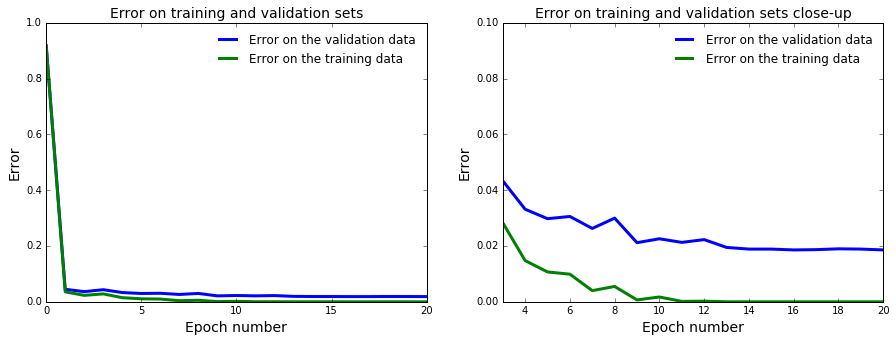

In [254]:
plt.figure(figsize=(15,5))
plt.clf()
plt.subplot(1,2,1)
plt.plot(range(0,epoch_num), validation_error,'-',lw=3)
plt.plot(range(0,epoch_num), training_error,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xlim(0,20)
plt.ylim(0.,1.)
plt.legend(['Error on the validation data','Error on the training data'],frameon = False)
plt.title('Error on training and validation sets',fontsize = 14)

plt.subplot(1,2,2)
plt.plot(range(0,epoch_num), validation_error,'-',lw=3)
plt.plot(range(0,epoch_num), training_error,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xlim(3,20)
plt.ylim(0,0.1)
plt.legend(['Error on the validation data','Error on the training data'],frameon = False)
plt.title('Error on training and validation sets close-up',fontsize = 14)
plt.show()

In [255]:
# Doing feedforward step for our test data to obtain predicted labels for our test data and then accuracy of our model
a2_test, a3_test, Y_predicted_test = FeedforwardCalculation2(X_test, Theta_1, Theta_2,Theta_3, b1, b2, b3)
Y_pred_output_test = np.argsort(Y_predicted_test, axis = 1)[:,-1]
Y_pred_output_test = Y_pred_output_test.reshape(-1,1)
        
Accuracy_test, Error_test = Accuracy(Y_pred_output_test, Y_test)        
print('Accuracy of the second model on the test data is %.2f%% ' % (100*Accuracy_test),
      'Error on the test data is %.2f%%' % (100*Error_test))
        

('Accuracy of the second model on the test data is 98.10% ', 'Error on the test data is 1.90%')


# Third model - same neural network architecture but  with droput

In [339]:
# Configuration of the neural network parameters
input_layer_size = 784        # 28x28 Input Images of Digits
hidden_layer_size1 = 300      # num of hidden units in the first hidden layer
hidden_layer_size2 = 300      # num of hidden units in the second hidden layer
num_labels = 10    
mini_batch_size = 50

dropout_rate1 = 0.10          # droput rate which will be applied on our input data
dropout_rate2 = 0.5           # droput rate which will be applied on our first layer activation values
# in this model the droput will not be used on our last layer

alpha = 0.0005                # weight decay parameter (L2 regularization parameter)
learning_rate = 0.1         # The learning rate of 0.1 was too big for this model, the rate of 0.003 is much better

In [340]:
def FeedforwardCalculation_with_dropout(X, Theta_1, Theta_2, Theta_3, b1, b2, b3):
    X_dropout_mask = np.random.binomial(1, 1-dropout_rate1, size = X.shape)
    # By multiplication with the new created matrix 10% of our inputs is being cancelled
    X_with_dropout = X * X_dropout_mask
    z1 = np.dot( X_with_dropout, Theta_1.T) + b1
    a2 = np.tanh(z1)
    a2_dropout_mask = np.random.binomial(1,1-dropout_rate2,size = a2.shape)
    # By multiplication with the new created matrix 50% of our activations in the first layer are being cancelled
    a2_with_dropout = a2*a2_dropout_mask
    z2 = np.dot(a2_with_dropout, Theta_2.T) + b2
    # The activations in our second hidden layer are left intact
    a3 = np.tanh(z2)
    z3 = np.dot(a3, Theta_3.T) + b3
     
    exponentials = np.exp(z3)
    y_predicted = exponentials / np.sum(exponentials, axis=1, keepdims=True)
          
    return a2, a3, y_predicted, X_dropout_mask, a2_dropout_mask

In [357]:
def BackpropagationCalculation_with_dropout(Y_predicted, Y_real, Theta_1,Theta_2,Theta_3,b1, b2, b3, X, a2,a3, learning_rate,
                                            mini_batch_size, X_dropout_mask, a2_dropout_mask):
    delta4 = Y_predicted - Y_real
    delta3 = np.dot(delta4, Theta_3 )*(1 - a3**2)
    delta2 = np.dot(delta3, Theta_2 )*(1 - a2**2)
    
    DELTA_3 = np.dot(a3.T, delta4) + alpha*Theta_3.T
    a2 = a2*a2_dropout_mask
    DELTA_2 = np.dot(a2.T, delta3) + alpha*Theta_2.T
    X = X * X_dropout_mask
    DELTA_1 = np.dot(X.T, delta2) + alpha*Theta_1.T
    DELTA_b3 = np.sum(delta4, axis=0, keepdims=True)
    DELTA_b2 = np.sum(delta3, axis=0, keepdims=True)
    DELTA_b1 = np.sum(delta2, axis=0)
    
    # Updating both weights (Theta_1, Theta_2 and Theta_3) and biases (b1. b2 and b3)
    Theta_1 = Theta_1 - 1/float(mini_batch_size)*learning_rate * DELTA_1.T
    Theta_2 = Theta_2 - 1/float(mini_batch_size)*learning_rate * DELTA_2.T
    Theta_3 = Theta_3 - 1/float(mini_batch_size)*learning_rate * DELTA_3.T
    b1 = b1 - 1/float(mini_batch_size)*learning_rate * DELTA_b1
    b2 = b2 - 1/float(mini_batch_size)*learning_rate * DELTA_b2
    b3 = b3 - 1/float(mini_batch_size)*learning_rate * DELTA_b3
    
    return Theta_1, Theta_2, Theta_3, b1, b2, b3

In [362]:
def Building_the_model_with_droput(input_layer_size,hidden_layer_size1, hidden_layer_size2, num_labels, learning_rate, X_train, 
                                   Y_train, X_validate, Y_validate, mini_batch_size, num_validation_examples, max_num_epochs):
    
    # Initializing weights
    Theta_1, Theta_2, Theta_3, b1, b2, b3 = Weights_Initialization2(input_layer_size, hidden_layer_size1, hidden_layer_size2,
                                                                   num_labels)
    A = np.matlib.repmat(np.arange(10), mini_batch_size,1)
    epoch_num = 0
    validation_error = []
    loss_on_validation_set =[] 
    training_error = []
    
    while epoch_num <=max_num_epochs:
        
        # Compute an error and loss on validation set:
        # First we need to do a feedforward step using features in validation set:
        # For our validation set we don't use droput
        if epoch_num >0:
            Theta_1_corrected = 0.9*Theta_1
            Theta_2_corrected = 0.5*Theta_2
        else:
            Theta_1_corrected = Theta_1
            Theta_2_corrected = Theta_2
            
        a2_valid, a3_valid, Y_predicted_valid = FeedforwardCalculation2(X_validate, Theta_1_corrected, Theta_2_corrected, 
                                                                        Theta_3, b1, b2, b3)
        Y_pred_output_valid = np.argsort(Y_predicted_valid, axis = 1)[:,-1]
        Y_pred_output_valid = Y_pred_output_valid.reshape(-1,1)
        
        Accuracy_valid, Error_valid = Accuracy(Y_pred_output_valid, Y_validate)
        loss_valid = Loss_Calculation(Y_predicted_valid, Y_validate)
        
        validation_error.append(Error_valid)
        loss_on_validation_set.append(loss_valid)
        
        if epoch_num % 5 == 0:
            print epoch_num,Error_valid,loss_valid
        
        # Do a feedforward step on our training data to obtain error and accuracy for our training data for each epoch
        a2, a3, Y_predicted_train = FeedforwardCalculation2(X_train, Theta_1, Theta_2_corrected, Theta_3_corrected, b1, b2, b3)
        Y_pred_output_train = np.argsort(Y_predicted_train, axis = 1)[:,-1]
        Y_pred_output_train = Y_pred_output_train.reshape(-1,1)
        
        # Calculcate Accuracy on our training data:
        Accuracy_train, Error_train = Accuracy(Y_pred_output_train, Y_train)
        training_error.append(Error_train)          

        # Applying Stochastic Gradient Descent with mini batch size of 50:

        for batch in create_minibatches(X_train, Y_train, mini_batch_size, shuffle=True):
            x_batch, y_batch = batch
            y_batch_matrix = (np.matlib.repmat(y_batch,10,1).T ==A).astype(int)
            
            # Do a feedforward step
            a2, a3, Y_predicted, X_dropout_mask, a2_dropout_mask = FeedforwardCalculation_with_dropout(x_batch, Theta_1,Theta_2, 
                                                                                                   Theta_3,b1, b2, b3)
                        
            # Do a backprop step
            Theta_1, Theta_2, Theta_3, b1, b2, b3 = BackpropagationCalculation_with_dropout(Y_predicted, y_batch_matrix, 
                                                                Theta_1, Theta_2, Theta_3, b1, b2, b3,x_batch, a2, a3, 
                                                                learning_rate, mini_batch_size, X_dropout_mask, a2_dropout_mask)
        epoch_num += 1
    
    return Theta_1, Theta_2, Theta_3, b1, b2, b3, epoch_num, validation_error, loss_on_validation_set, training_error

In [348]:
# Running our final model with 2 hidden layers of sizes 300 and 300 respectively and learning rate of 0.1 to obtain 
# needed weights:

Theta_1, Theta_2, Theta_3, b1, b2, b3, epoch_num, validation_error, loss_on_validation_set, training_error = \
                                                    Building_the_model_with_droput(input_layer_size,
                                                    hidden_layer_size1, hidden_layer_size2, num_labels,learning_rate,X_train,
                                                    Y_train, X_validate,Y_validate, mini_batch_size, num_validation_examples,100)

0 0.917433026789 2.36957990804
5 0.0520791683327 0.172457699406
10 0.0378848460616 0.123098981271
15 0.03168732507 0.104148554422
20 0.0276889244302 0.0914546534635
25 0.0249900039984 0.0802210476758
30 0.0227908836465 0.0771713364346
35 0.0236905237905 0.0761246126023
40 0.0211915233906 0.0704542604374
45 0.0207916833267 0.0706810866625
50 0.0208916433427 0.0703166103053
55 0.0205917632947 0.0687551639779
60 0.0198920431827 0.0658718015218
65 0.0196921231507 0.0657040173298
70 0.0186925229908 0.0681334046042
75 0.0182926829268 0.0631099606115
80 0.0178928428629 0.0642352543252
85 0.0180927628948 0.0629560296597
90 0.0174930027989 0.063417258011
95 0.0172930827669 0.0604071286592
100 0.0182926829268 0.0611919774317


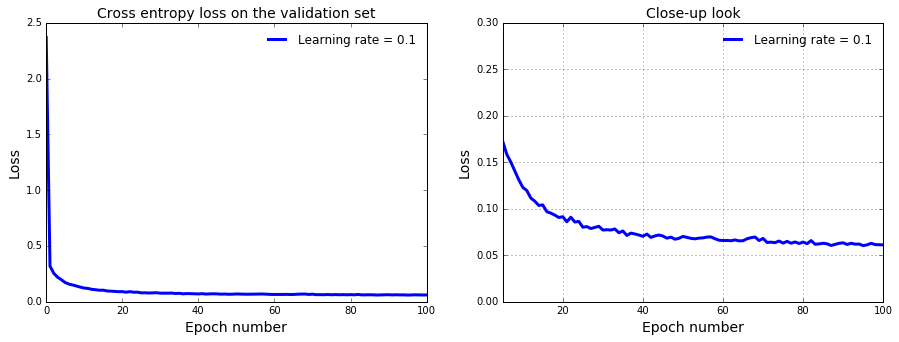

In [356]:
plt.figure(figsize=(15,5))
plt.clf()
plt.subplot(1,2,1)
plt.plot(range(0,epoch_num), loss_on_validation_set,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.xlim(0,100)
plt.legend(['Learning rate = 0.1'], frameon = False)
plt.title('Cross entropy loss on the validation set',fontsize = 14)

plt.subplot(1,2,2)
plt.plot(range(0,epoch_num), loss_on_validation_set, linestyle = '-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.xlim(5,100)
plt.ylim(0.0,0.3)
plt.legend(['Learning rate = 0.1'], frameon = False)
plt.title('Close-up look',fontsize = 14)
plt.show()

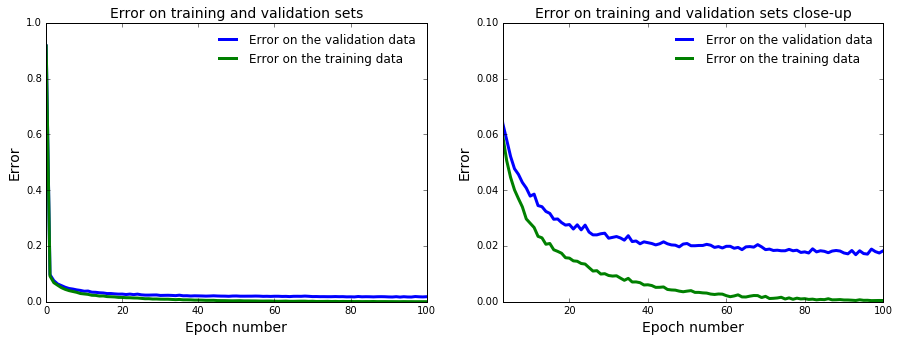

In [353]:
plt.figure(figsize=(15,5))
plt.clf()
plt.subplot(1,2,1)
plt.plot(range(0,epoch_num), validation_error,'-',lw=3)
plt.plot(range(0,epoch_num), training_error,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xlim(0,100)
plt.ylim(0.,1.)
plt.legend(['Error on the validation data','Error on the training data'],frameon = False)
plt.title('Error on training and validation sets',fontsize = 14)

plt.subplot(1,2,2)
plt.plot(range(0,epoch_num), validation_error,'-',lw=3)
plt.plot(range(0,epoch_num), training_error,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xlim(3,100)
plt.ylim(0,0.1)
plt.legend(['Error on the validation data','Error on the training data'],frameon = False)
plt.title('Error on training and validation sets close-up',fontsize = 14)
plt.show()

In [354]:
#Correcting our obtained weights before using them to get the test error
Theta_1_corrected = 0.9*Theta_1
Theta_2_corrected = 0.5*Theta_2

In [355]:
# Doing feedforward step without droput for our test data to obtain predicted labels for our test data and then accuracy of 
# our model
a2_test, a3_test, Y_predicted_test = FeedforwardCalculation2(X_test, Theta_1_corrected, Theta_2_corrected,Theta_3, b1, b2, b3)
Y_pred_output_test = np.argsort(Y_predicted_test, axis = 1)[:,-1]
Y_pred_output_test = Y_pred_output_test.reshape(-1,1)
        
Accuracy_test, Error_test = Accuracy(Y_pred_output_test, Y_test)        
print('Accuracy of the third model on the test data is %.2f%% ' % (100*Accuracy_test),
      'Error on the test data is %.2f%%' % (100*Error_test))

('Accuracy of the third model on the test data is 98.37% ', 'Error on the test data is 1.63%')


I trained a third model only for 100 epochs eventhough it looks like it can gain in accuracy from further training for 
time saving resons. 